## Notebook to characterise the prediction in the test cohort for Graph model
- characterise the prediction features 
- analyse sensitivity and ppv as cluster size
- map sensitivity and ppv spatial location 

In [ ]:
import os
import sys
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import ptitprince as pt
import seaborn as sns
import pandas as pd


In [2]:
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [3]:
from meld_graph.dataset import GraphDataset
from meld_graph.evaluation import Evaluator
import matplotlib as mpl
import matplotlib.cm as cm
from meld_graph.data_preprocessing import Preprocess
from meld_graph.confidence import get_confidence
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image


In [4]:
dataset = 'test'  # "test" or "H101"

model_graph = '23-10-30_LVHZ_dcp/s_0/fold_all_newthreshold'

In [ ]:
# load experiment
exp = meld_graph.experiment.Experiment.from_folder(model_graph)
exp.data_parameters["augment_data"] = {}

#load trainval dataset
split = "test"

cohort = MeldCohort(
        hdf5_file_root=exp.data_parameters["hdf5_file_root"],
        dataset=exp.data_parameters["dataset"],
    )

features = exp.data_parameters["features"]

# get only test patients
with h5py.File(os.path.join(model_graph, 'results_best_model', 'predictions.hdf5'), "r") as f:
    subjects = list(f.keys())

subjects = [subject for subject in subjects if '_FCD_' in subject]
# print(len(subjects))




### Compute mean saliencies 

In [6]:
# setup parameters
base_feature_sets = [
    ".on_lh.curv.sm3.mgh",
    ".on_lh.pial.K_filtered.sm20.mgh",
    ".on_lh.sulc.sm3.mgh",
    ".on_lh.thickness_regression.sm3.mgh",
    ".on_lh.w-g.pct.sm3.mgh",
    ".on_lh.gm_FLAIR_0.5.sm3.mgh",
    ".on_lh.wm_FLAIR_1.sm3.mgh",
]

feature_names_sets = {
   ".on_lh.gm_FLAIR_0.5.sm3.mgh": "GM FLAIR (50%)",
    ".on_lh.wm_FLAIR_1.sm3.mgh": "WM FLAIR (1mm)",
    ".on_lh.curv.sm3.mgh": "Mean curvature",
    ".on_lh.pial.K_filtered.sm20.mgh" :"Intrinsic Curvature",
    ".on_lh.sulc.sm3.mgh": "Sulcal depth",
    ".on_lh.thickness_regression.sm3.mgh":"Cortical thickness",
    ".on_lh.w-g.pct.sm3.mgh": "Grey-white contrast"}

In [ ]:
# create evaluator

# subjects = subjects[20:40]

dataset = GraphDataset(subjects, cohort, exp.data_parameters, mode="test")
save_prediction_suffix=""


eva = Evaluator(
    experiment=exp,
    checkpoint_path=model_graph,
    make_images=False,
    dataset=dataset,
    save_dir=None,
    cohort=cohort,
    subject_ids=subjects,
    mode="test",
    thresh_and_clust=True,
)

In [ ]:
import pandas as pd 

eva.dropout_suffix = ""
NVERT=293804
values={}
df_salient = pd.DataFrame()
predictions_array=[]
labels_array = []
tp_fp_array = []
fn_array = []
for subject_id in subjects:
    subject = MeldSubject(subject_id, cohort=cohort)
    values['ID'] = subject_id
    values['group'] = True if '_FCD_' in subject_id else False
    values['histology'] = subject.get_demographic_features(["Histology"])[0]
    # initialise parameter for plot
    if subject.has_flair:
        base_features = base_feature_sets
    else:
        base_features = base_feature_sets[0:-2]
    # load predictions and data subject
    data_dictionary = eva.load_data_from_file(subject_id, keys=['result','cluster_thresholded','input_features'], 
                                          split_hemis=True, )
    # print(data_dictionary)
    features_vals = data_dictionary['input_features']
    predictions = data_dictionary['cluster_thresholded']
    
    labels_hemis={}
    dists={}
    list_clust={}
    saliencies={}
     # Loop over hemi
    for i, hemi in enumerate(["left", "right"]):
        list_clust[hemi] = set(predictions[hemi])
        list_clust[hemi].remove(0.0)
        #get borderzone
        hemi_bis = 'lh' if hemi=='left' else 'rh'
        dists[hemi], labels_hemis[hemi] = subject.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi_bis, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
        borderzones = np.zeros(len(dists[hemi]))
        borderzones[cohort.cortex_mask] = dists[hemi].ravel()[cohort.cortex_mask]<20
        # get saliencies
        keys = [f'saliencies_{cl}' for cl in list_clust[hemi]] + [f'mask_salient_{cl}' for cl in list_clust[hemi]]
        saliencies.update(eva.load_data_from_file(subject_id, 
                                            keys=keys, 
                                            split_hemis=True))
        # initiate params for saliencies
        prefixes = [".combat", ".inter_z.intra_z.combat", ".inter_z.asym.intra_z.combat"]
        labels = ["Harmonised", "Normalised", "Asymmetry"]
        # loop over clusters
        for cluster in list_clust[hemi]:
            values['cluster'] = cluster
            # get prediction
            predictions_array.append(predictions[hemi]==cluster)
            values['cluster_size'] = (predictions[hemi]==cluster).sum()
            # get saliency cluster
            saliencies_cl = saliencies[f'saliencies_{cluster}'][hemi]
            saliencies_cl = saliencies_cl * (NVERT/2)
            # get salient vertices
            mask_salient = saliencies[f'mask_salient_{cluster}'][hemi].astype(bool)
            if ((predictions[hemi]==cluster)&(borderzones.astype(bool))).any():
                values['detected'] = True
                tp_fp_array.append(True)
            else:
                values['detected'] = False
                tp_fp_array.append(False)
            # for each feature
            for pr, prefix in enumerate(prefixes):
                values['preprocessing'] = prefix
                for b, bf in enumerate(base_features):
                    values['feature'] = bf
                    values[f'feature_mean'] = np.mean(
                        np.array(features_vals[hemi][mask_salient, features.index(prefix + bf)])
                    )
                    values[f'feature_err'] = np.std(
                        np.array(features_vals[hemi][mask_salient, features.index(prefix + bf)])
                    )
                    values[f'saliency'] = np.mean(
                        saliencies_cl[mask_salient ,features.index(prefix + bf)]
                        )
                    df_salient = pd.concat([df_salient, pd.DataFrame([values])])
        # for lesion mask
        if labels_hemis[hemi].sum()!=0:
            mask = labels_hemis[hemi].astype(bool)
            labels_array.append(mask)
            values['cluster'] = 'lesion_mask'
            values['cluster_size'] = mask.sum()
            if ((predictions[hemi]>0==cluster)&(borderzones.astype(bool))).any():
                values['detected'] = True
                fn_array.append(False)
            else:
                values['detected'] = False
                fn_array.append(True)
            # for each feature
            for pr, prefix in enumerate(prefixes):
                values['preprocessing'] = prefix
                for b, bf in enumerate(base_features):
                    values['feature'] = bf
                    values[f'feature_mean'] = np.mean(
                        np.array(features_vals[hemi][mask, features.index(prefix + bf)])
                    )
                    values[f'feature_err'] = np.std(
                        np.array(features_vals[hemi][mask, features.index(prefix + bf)])
                    )
                    values[f'saliency'] = np.nan
                    df_salient = pd.concat([df_salient, pd.DataFrame([values])])
                
df_salient.head()

In [7]:
# save or load dataframes
import pickle

file = os.path.join(model_graph, 'dataframe_saved', 'df_test_saliencies_240821.csv')
file_pkl = os.path.join(model_graph, 'dataframe_saved', 'df_test_tp_fp_prediction_240821.pkl')

# save data
# df_salient.to_csv(file)
# data = {'predictions_array':predictions_array, 
#         'tp_fp_array': tp_fp_array,
#         'fn_array': fn_array, 
#         'labels_array':labels_array
#         }
# with open(file_pkl, 'wb') as f:
#         pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

# load data
df_salient = pd.read_csv(file)
with open(file_pkl, 'rb') as f:
        data = pickle.load(f)
predictions_array = data['predictions_array']
tp_fp_array = data['tp_fp_array']
labels_array = data['labels_array']
fn_array = data['fn_array']

In [8]:
def return_group_analysis(row):
    if (row['cluster']!='lesion_mask')&(row['detected']==True):
        group_analysis='TP'
    elif (row['cluster']!='lesion_mask')&(row['detected']==False):
        group_analysis='FP'
    elif (row['cluster']=='lesion_mask')&(row['detected']==False):
        group_analysis='FN'
    else:
        group_analysis=np.nan
    return group_analysis

def return_histo_analysis(row):
    if (row['cluster']!='lesion_mask')&(row['detected']==True)&((row['histology']=='FCD_1')|(row['histology']=='FCD_3')):
        group_analysis='FCD 1&3'
    elif (row['cluster']!='lesion_mask')&(row['detected']==True)&(row['histology']=='FCD_2A'):
        group_analysis='FCD 2A'
    elif (row['cluster']!='lesion_mask')&(row['detected']==True)&(row['histology']=='FCD_2B'):
        group_analysis='FCD 2B'
    else:
        group_analysis=np.nan
    return group_analysis

## plot features fingerprints

/tmp/ipykernel_3244398/1052956713.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['group_analysis'] = sub_df.apply(lambda row: return_group_analysis(row), axis=1)


.on_lh.curv.sm3.mgh
[0.99564955 0.01929426 0.0601275 ]
.on_lh.pial.K_filtered.sm20.mgh
[3.53010940e-05 2.88158386e-12 1.54500798e-02]
.on_lh.sulc.sm3.mgh
[1.25094914e-02 8.91123529e-08 2.78184800e-02]
.on_lh.thickness_regression.sm3.mgh
[5.13938269e-07 0.00000000e+00 8.72578849e-03]
.on_lh.w-g.pct.sm3.mgh
[2.23129203e-05 0.00000000e+00 1.31862104e-04]
.on_lh.gm_FLAIR_0.5.sm3.mgh
[4.92114103e-02 3.14464711e-05 4.10827709e-02]
.on_lh.wm_FLAIR_1.sm3.mgh
[0.21749686 0.67495939 0.87730662]
p-value annotation legend:
       *: 1.00e-03 < p <= 5.00e-02
      **: p <= 1.00e-03

.on_lh.pial.K_filtered.sm20.mgh_FP vs. .on_lh.pial.K_filtered.sm20.mgh_FN: Custom statistical test, P_val:1.545e-02
.on_lh.sulc.sm3.mgh_TP vs. .on_lh.sulc.sm3.mgh_FP: Custom statistical test, P_val:1.251e-02
.on_lh.sulc.sm3.mgh_FP vs. .on_lh.sulc.sm3.mgh_FN: Custom statistical test, P_val:2.782e-02
.on_lh.thickness_regression.sm3.mgh_TP vs. .on_lh.thickness_regression.sm3.mgh_FP: Custom statistical test, P_val:5.139e-07

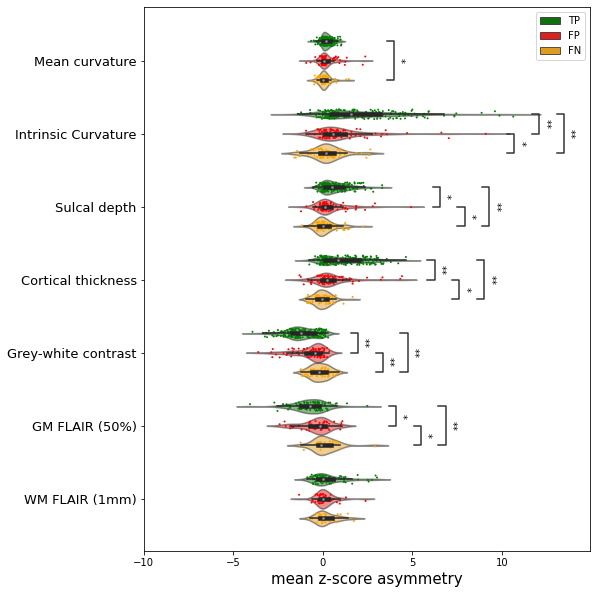

In [9]:
from scipy.stats import f_oneway,tukey_hsd
import seaborn as sns
from matplotlib.collections import PathCollection
from statannotations.Annotator import Annotator
import statsmodels.stats.multitest as multi


analysis = ['TP','FP','FN']
# analysis = ['FCD 1&3', 'FCD 2A', 'FCD 2B']

preprocessing = ".inter_z.asym.intra_z.combat"

sub_dfs = []
    
# get characteristic of analysis
sub_df = df_salient[df_salient['preprocessing']==preprocessing]
if analysis == ['TP','FP','FN']:
    sub_df['group_analysis'] = sub_df.apply(lambda row: return_group_analysis(row), axis=1)
    colors = {'TP':'green', 'FP':'red', 'FN':'orange',}
    xlims = [-10,10]
elif analysis == ['FCD 1&3', 'FCD 2A', 'FCD 2B'] :
    sub_df['group_analysis'] = sub_df.apply(lambda row: return_histo_analysis(row), axis=1)
    xlims = [-10,10]
    colors = {'FCD 1&3':'violet', 'FCD 2A':'darkblue', 'FCD 2B':'cyan'}
else:
    print('analysis not set up')
    
sub_df.dropna(subset='group_analysis')

# plot mean z-score features distribution
fig_args = {'x': "feature_mean" , 
            'y' : "feature", 
            'data': sub_df, 
            'order': base_feature_sets,
            'hue':"group_analysis", 
            'hue_order':analysis,
            'dodge': True,
            'palette': colors}

f, ax = plt.subplots(figsize=(8, 10))
# add the violin plots
sns.violinplot(**fig_args, ax=ax)
plt.setp(ax.collections, alpha=.5) 

# add the dots 
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
sns.stripplot(**fig_args,
              jitter=0.2, size=2,
              ax=ax)

# rename yticks by features
new_y_ticks = [feature_names_sets[x] for x in base_feature_sets ] 
ax.set_yticklabels(new_y_ticks, fontsize=13)
ax.set_xlim(xlims)

# rename and limit xticks
ax.set_xlabel('mean z-score asymmetry', fontsize=15)
ax.set_ylabel('',)

# Apply Tukey’s HSD test
pvalues = np.ones([len(base_feature_sets),len(analysis)])
for i,feature in enumerate(base_feature_sets):    
    data = (sub_df[(sub_df['feature']==feature)&(sub_df['group_analysis']==analysis[0])]['feature_mean'].values,
            sub_df[(sub_df['feature']==feature)&(sub_df['group_analysis']==analysis[1])]['feature_mean'].values,
            sub_df[(sub_df['feature']==feature)&(sub_df['group_analysis']==analysis[2])]['feature_mean'].values)
    res = tukey_hsd(data[0], data[1], data[2])
    pvalues[i] = [res.pvalue[0,1], res.pvalue[0,2], res.pvalue[1,2]]
    print(feature)
    print(pvalues[i])
   
# no need to correct for multiple comparison as family-wise error in Tukey test already
# matrix_pvals_cor = (multi.multipletests(pvalues.flatten(), alpha=0.05, method='holm')[1]).reshape((len(base_feature_sets),len(analysis)))
# print(matrix_pvals_cor)

# format pairs and pvalues
pairs = []
pvalues_pairs = []
for i,feature in enumerate(base_feature_sets):
    for p, pair in enumerate([[analysis[0],analysis[1]],[analysis[0],analysis[2]],[analysis[1],analysis[2]]]):
        pairs.append(((feature,pair[0]), (feature,pair[1])))
        pvalues_pairs.append(pvalues[i,p])  

# create annotator
annotator = Annotator(ax=ax, pairs=pairs,
                      **fig_args, orient='h', plot='stripplot')

# provide the pvalues from the Tukey test
configuration = {
                 'text_format':'star', 
                 'hide_non_significant':True,
                 'pvalue_thresholds':[[0.001, "**"], [0.05, "*"]],
                    }
annotator.configure(**configuration)
annotator.set_pvalues(pvalues_pairs).annotate()

# # OR apply test in the annotator 
# configuration = {
#                 'test':'t-test_ind',
#                  'comparisons_correction':'holm',
#                  'text_format':'star', 
#                  'hide_non_significant':True,
#                  'pvalue_thresholds':[[0.001, "**"], [0.05, "*"]],
#                     }
# annotator.configure(**configuration)
# annotator.apply_test().annotate()

# update legend
handles, previous_labels = ax.get_legend_handles_labels()
new_handles = handles[0:3] 
new_labels = previous_labels[0:3]
ax.legend(handles=new_handles, labels=new_labels)

plt.show()




### plot sensitivity and ppv as function of lesion size

In [38]:
def return_sensitivity_ppv(array):
    ''' array of TP, FP and FN '''
    TP = np.sum(array=='TP')
    FP = np.sum(array=='FP')
    FN = np.sum(array=='FN')
    sensitivity = TP / (TP+FN)
    ppv = TP / (TP+FP)  
    return sensitivity, ppv


349
[ 243  427  739  939 1301 1646 1970 2337 2677 3310]


/tmp/ipykernel_3244398/2986063100.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['group_analysis'] = sub_df.apply(lambda row: return_group_analysis(row), axis=1)
/tmp/ipykernel_3244398/2986063100.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['bin'] = digitized
/tmp/ipykernel_3244398/2986063100.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(bins, sensitivi

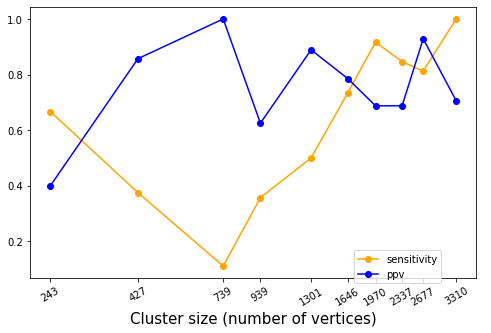

In [39]:
log = False

preprocessing = ".inter_z.asym.intra_z.combat"
feature = '.on_lh.thickness_regression.sm3.mgh' # just to get one value

sub_dfs = []

analysis = ['TP', 'FP', 'FN']  
# get sub dataset
sub_df = df_salient[(df_salient['preprocessing']==preprocessing) & (df_salient['feature']==feature) ]
sub_df['group_analysis'] = sub_df.apply(lambda row: return_group_analysis(row), axis=1)
sub_df = sub_df.dropna(subset=['group_analysis'])
print(len(sub_df))

# create bins of cluster size
data = sub_df['cluster_size'].values
    
# bins = np.linspace(data.min(), data.max(), 10)
bins = np.array([np.percentile(data, x*5) for x in range(1,11)]).astype(int)
print(bins)
digitized = np.digitize(data, bins)
sub_df['bin'] = digitized
# plt.figure()
# plt.hist(sub_df['bin'].values)
# get sensitivity, ppv for each bins
sensitivity_bins=[]
ppv_bins= []
for bin,_ in enumerate(bins):
    sensitivity, ppv = return_sensitivity_ppv(sub_df[sub_df['bin']==bin]['group_analysis'].values)
    sensitivity_bins.append(sensitivity)
    ppv_bins.append(ppv)
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(bins, sensitivity_bins, '-ro', color='orange',  label='sensitivity')
ax.plot(bins, ppv_bins, '-ro', color='blue', label='ppv')


# scale xaxis as log    
ax.set_xlabel('Cluster size (number of vertices)', fontsize=15)
ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks(bins)
ax.set_xticklabels(bins, rotation=30)

# ax.set_xticklabels([f'[0-{bins[0]}]']+[f'[{bins[i]}-{bins[i+1]}]' for i in range(0, len(bins)-1)], rotation=45)

fig.legend(loc='lower right', borderaxespad=5)
plt.show()

[0.52  0.006 0.    0.008 0.072 0.906 0.106 0.248 0.478 0.   ]
[0.024 0.142 0.    0.644 0.084 0.338 0.946 0.968 0.028 0.892]


/tmp/ipykernel_3244398/934299098.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(bins, sensitivity_bins, '-ro', color='orange',  label='sensitivity', zorder=1)
/tmp/ipykernel_3244398/934299098.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(bins, ppv_bins, '-ro', color='blue', label='ppv', zorder=1)


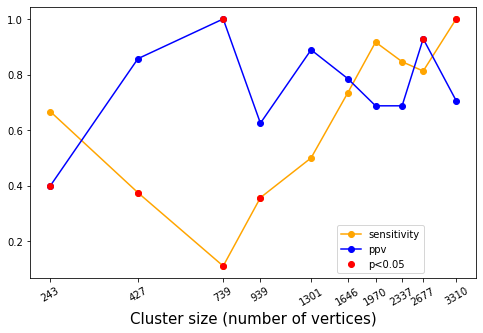

In [40]:
# compute significance with shuffling
import random

def get_pvalue(stat, distribution):
    p_pos = np.mean(distribution > stat)
    p_neg = np.mean(distribution < stat)
    p = min(p_pos,p_neg)*2
    return p

def add_CI_bar(CI, val, ax, color='blue'):
    ax.plot((val,val),(CI[0],CI[1,]),'-',color=color)
    ax.plot((val-0.1,val+0.1), (CI[0],CI[0]),'-',color=color)
    ax.plot((val-0.1,val+0.1),(CI[1],CI[1]),'-',color=color)
    return ax

iteration = 1000

sensitivity_bins_shuffle = np.zeros((iteration, len(bins)))
ppv_bins_shuffle = np.zeros((iteration, len(bins)))
for i in range(0, iteration):
    sub_df_i = sub_df.copy()
    #shuffle array TP, FP, FN
    random.shuffle(sub_df_i['group_analysis'].values)
    # get sensitivity, ppv for each bins
    for bin,_ in enumerate(bins):
        sensitivity_bins_shuffle[i,bin], ppv_bins_shuffle[i,bin] = return_sensitivity_ppv(sub_df_i[sub_df_i['bin']==bin]['group_analysis'].values)
        
# compute pvalue
pval_sensitivity_bins = np.array([get_pvalue(sensitivity_bins[i], sensitivity_bins_shuffle[:,i]) for i,_ in enumerate(bins)])
print(pval_sensitivity_bins)
pval_ppv_bins = np.array([get_pvalue(ppv_bins[i], ppv_bins_shuffle[:,i]) for i,_ in enumerate(bins)])
print(pval_ppv_bins)
CI_sensitivity_bins = [np.percentile(np.array(sensitivity_bins_shuffle[:,i]), [2.5, 97.5],axis=0) for i,_ in enumerate(bins)]
CI_ppv_bins = [np.percentile(np.array(ppv_bins_shuffle[:,i]), [2.5, 97.5],axis=0) for i,_ in enumerate(bins)]

# plot with CI
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(bins, sensitivity_bins, '-ro', color='orange',  label='sensitivity', zorder=1)
ax.plot(bins, ppv_bins, '-ro', color='blue', label='ppv', zorder=1)
significant_sensitivity = (pval_sensitivity_bins<0.05)
ax.scatter(bins[significant_sensitivity], np.array(sensitivity_bins)[significant_sensitivity], marker='o', color='red', label='p<0.05', zorder=2)
significant_ppv= (pval_ppv_bins<0.05)
ax.scatter(bins[significant_ppv], np.array(ppv_bins)[significant_ppv], marker='o', color='red', zorder=2)
    
# for bin, val_bin in enumerate(bins):
    # ax = add_CI_bar(CI_sensitivity_bins[bin], np.log(val_bin), ax, color='orange')
    # ax = add_CI_bar(CI_ppv_bins[bin], np.log(val_bin), ax, color='blue')


# scale xaxis as log    
ax.set_xlabel('Cluster size (number of vertices)', fontsize=15)
ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks(bins)
ax.set_xticklabels(bins, rotation=30)
    
ax.set_xlabel('Cluster size (number of vertices)', fontsize=15)

fig.legend(loc='lower right', borderaxespad=6)
plt.show()

### plot spatial distribution of sensitivity and ppv

In [26]:
def create_surface_plots(surf,prediction,c, base_size=20, vmin=0, vmax=1, pvals=None):
    """plot and reload surface images"""
    tmp_file = 'tmp.png'
    if pvals is None:
      pvals = np.ones_like(c.cortex_mask)
    msp.plot_surf(surf['coords'],
              surf['faces'],prediction,
              rotate=[90],
              pvals=pvals,
              cmap='viridis',
              colorbar = True,
              mask = ~c.cortex_mask,
              base_size=base_size,
              vmin=vmin, vmax=vmax,
              filename=tmp_file)
    im = Image.open(tmp_file)
    im = trim(im)
    im = im.convert("RGBA")
    im1 = np.array(im)
    msp.plot_surf(surf['coords'],
            surf['faces'],prediction,
              rotate=[270],
              pvals=pvals,
              cmap='viridis',
              base_size=base_size,
              mask = ~c.cortex_mask,
              vmin=vmin, vmax=vmax,
              filename=tmp_file)
    im = Image.open(tmp_file)
    im = trim(im)
    im = im.convert("RGBA")
    im2 = np.array(im)
    plt.close('all')
    os.remove(tmp_file)
    return im1,im2

In [13]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs1 = GridSpec(2, 2,)

tp_fp_array = np.array(tp_fp_array)
predictions_array = np.array(predictions_array)
fn_array = np.array(fn_array)
labels_array = np.array(labels_array)

# get TP, FP and FN 
TP_map = predictions_array[tp_fp_array].astype(int).sum(axis=0)
FP_map = predictions_array[~tp_fp_array].astype(int).sum(axis=0)
FN_map = labels_array[fn_array].astype(int).sum(axis=0)

# get sensitivity and ppv
sensitivity_map = TP_map / (TP_map+FN_map)
sensitivity_map[np.isnan(sensitivity_map)] = 0
ppv_map = TP_map / (TP_map+FP_map) 
ppv_map[np.isnan(ppv_map)] = 0 

# plot
im1, im2 = create_surface_plots(cohort.surf, prediction=sensitivity_map, 
                                c=cohort, base_size=10, 
                                vmin=0.5, vmax=max(sensitivity_map),
                                )
ax = fig.add_subplot(gs1[0, 0])
ax.imshow(im1)
ax.axis("off")                
ax = fig.add_subplot(gs1[0, 1])
ax.imshow(im2)
ax.axis("off")
ax.set_title('sensitivity')

im1, im2 = create_surface_plots(cohort.surf, prediction=ppv_map, 
                                c=cohort, base_size=10, 
                                vmin=0.4, vmax=max(ppv_map)
                                )
ax = fig.add_subplot(gs1[1, 0])
ax.imshow(im1)
ax.axis("off")                
ax = fig.add_subplot(gs1[1, 1])
ax.imshow(im2)
ax.axis("off")
ax.set_title('ppv')

fig.savefig(f"tmp.png", facecolor='white')



/tmp/ipykernel_3244398/980011090.py:15: RuntimeWarning: invalid value encountered in true_divide
  sensitivity_map = TP_map / (TP_map+FN_map)
/tmp/ipykernel_3244398/980011090.py:17: RuntimeWarning: invalid value encountered in true_divide
  ppv_map = TP_map / (TP_map+FP_map)
/tmp/ipykernel_3244398/980011090.py:45: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f"tmp.png", facecolor='white')


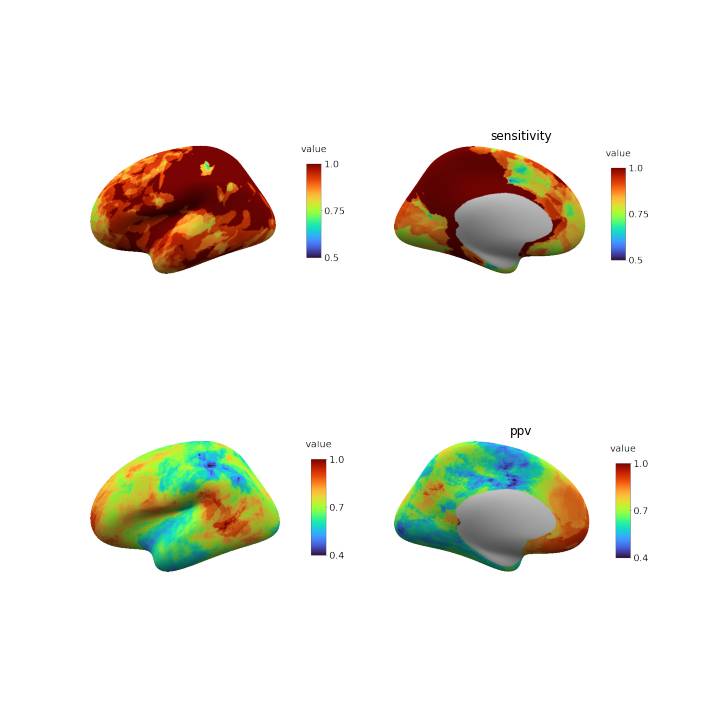

In [14]:
from IPython.display import display
from PIL import Image
display(Image.open("tmp.png"))

In [29]:
# find significance with permutation
import random 

def get_pvalue_array(array, distribution_array):
    p_pos = np.mean((distribution_array > array), axis=0)
    p_neg = np.mean((distribution_array < array), axis=0)
    p = np.min(np.array([p_pos,p_neg]), axis=0)*2
    return p

iteration=1000

sensitivity_map_i = np.zeros((iteration, len(sensitivity_map)))
ppv_map_i = np.zeros((iteration, len(ppv_map)))
for i in range(0, iteration):
    #shuffle array TP, FP, FN
    tp_fp_array_i = tp_fp_array.copy()
    random.shuffle(tp_fp_array_i)
    fn_array_i = fn_array.copy()
    random.shuffle(fn_array_i)
    #get new TP, FP, FN
    TP_map_i = predictions_array[tp_fp_array_i].astype(int).sum(axis=0)
    FP_map_i = predictions_array[~tp_fp_array_i].astype(int).sum(axis=0)
    FN_map_i = labels_array[fn_array_i].astype(int).sum(axis=0)
    # get sensitivity and ppv
    sensitivity_map_i[i] = TP_map_i / (TP_map_i+FN_map_i)
    sensitivity_map_i[i][np.isnan(sensitivity_map_i[i])] = 0
    ppv_map_i[i] = TP_map_i / (TP_map_i+FP_map_i) 
    ppv_map_i[i][np.isnan(ppv_map_i[i])] = 0

sensitivity_map_pval = get_pvalue_array(sensitivity_map, sensitivity_map_i)
ppv_map_pval = get_pvalue_array(ppv_map, ppv_map_i)


/tmp/ipykernel_3244398/3597185939.py:25: RuntimeWarning: invalid value encountered in true_divide
  sensitivity_map_i[i] = TP_map_i / (TP_map_i+FN_map_i)
/tmp/ipykernel_3244398/3597185939.py:27: RuntimeWarning: invalid value encountered in true_divide
  ppv_map_i[i] = TP_map_i / (TP_map_i+FP_map_i)


In [36]:
# correct for multiple comparison
sensitivity_map_pval_cor = multi.multipletests(sensitivity_map_pval, alpha=0.05, method='holm')[1]
ppv_map_pval_cor = multi.multipletests(ppv_map_pval, alpha=0.05, method='holm')[1]

# plot
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs1 = GridSpec(2, 2,)
im1, im2 = create_surface_plots(cohort.surf, prediction=sensitivity_map, 
                                c=cohort, base_size=10, 
                                vmin=0.4, vmax=1, 
                                pvals = (sensitivity_map_pval_cor<0.05)&(cohort.cortex_mask),
                                )
ax = fig.add_subplot(gs1[0, 0])
ax.imshow(im1)
ax.axis("off")                
ax = fig.add_subplot(gs1[0, 1])
ax.imshow(im2)
ax.axis("off")
ax.set_title('sensitivity')

im1, im2 = create_surface_plots(cohort.surf, prediction=ppv_map, 
                                c=cohort, base_size=10,
                                pvals = (ppv_map_pval_cor<0.05)&(cohort.cortex_mask),
                                vmin=0.4, vmax=1
                                )
ax = fig.add_subplot(gs1[1, 0])
ax.imshow(im1)
ax.axis("off")                
ax = fig.add_subplot(gs1[1, 1])
ax.imshow(im2)
ax.axis("off")
ax.set_title('ppv')

fig.savefig(f"tmp.png", facecolor='white')

/tmp/ipykernel_3244398/1020363044.py:34: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f"tmp.png", facecolor='white')


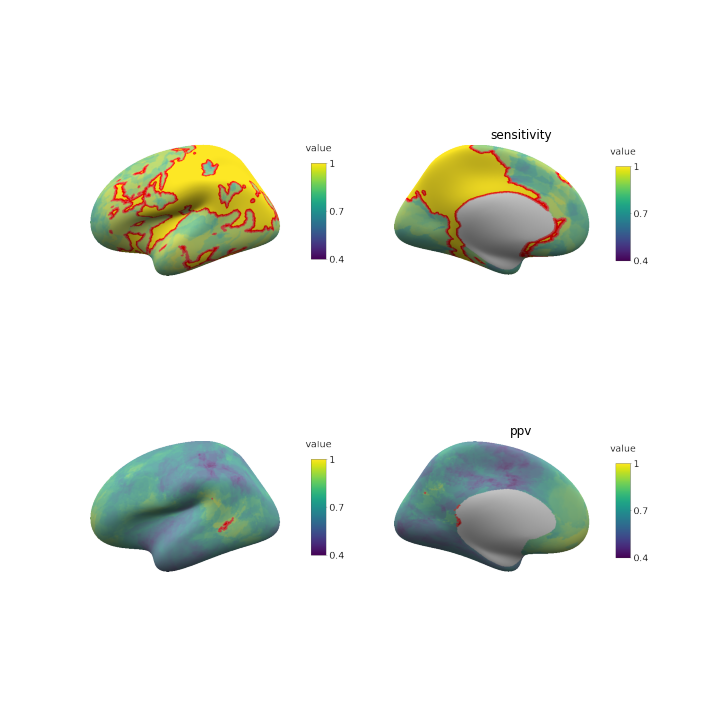

In [37]:
from IPython.display import display
from PIL import Image
display(Image.open("tmp.png"))